# Title: Yassir ETA Prediction Challenge
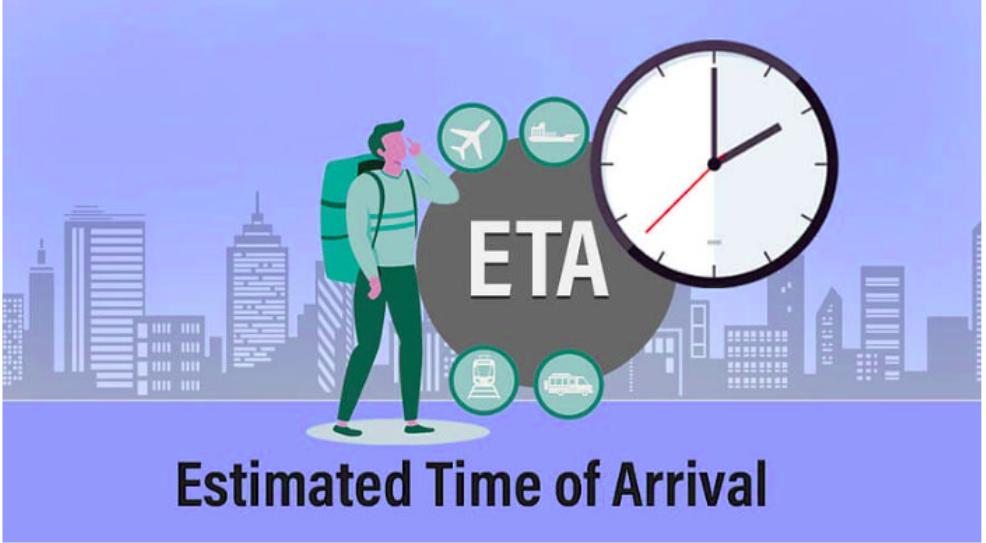

# Description

Ride-hailing apps like Uber and Yassir rely on real-time data and machine learning algorithms to automate their services. Accurately predicting the estimated time of arrival (ETA) for Yassir trips will make Yassir’s services more reliable and attractive; this will have a direct and indirect impact on both customers and business partners. The solution would help the company save money and allocate more resources to other parts of the business.

The objective of this notebook is to predict the estimated time of arrival at the dropoff point for a single Yassir journey.

# Importation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
import os
warnings.filterwarnings("ignore")

import pickle

# Data Loading

In [ ]:
train = pd.read_csv('../../assets/data/Train.csv')

test = pd.read_csv('../../assets/data/Test.csv')


sample = pd.read_csv('../../assets/data/SampleSubmission.csv')
weather = pd.read_csv('../../assets/data/Weather.csv')

# Dataset overview

In [ ]:
train.head(2)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
0,000FLWA8,2019-12-04T20:01:50Z,3.258,36.777,3.003,36.718,39627,2784
1,000RGOAM,2019-12-10T22:37:09Z,3.087,36.707,3.081,36.727,3918,576


In [ ]:
test.head(2)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
0,000V4BQX,2019-12-21T05:52:37Z,2.981,36.688,2.978,36.754,17549
1,003WBC5J,2019-12-25T21:38:53Z,3.032,36.769,3.074,36.751,7532


In [ ]:
# create a copy of test for submissions later
test_copy = test.copy()

sort the train set by date (timestamp)

In [ ]:
# make sure sorted by date
train = train.sort_values('Timestamp')

Split the datetime column into date and time components in both the train and test DataFrames.

In [ ]:
# split datetime column into date and time
def split_datetime_column(df, date):
    df['time'] = df[date].str[10:]
    df['date'] = df[date].str[:10]
    df.drop(columns=['Timestamp', 'ID'], inplace = True, axis=1)
    return df
train = split_datetime_column(train, 'Timestamp')
test = split_datetime_column(test, 'Timestamp')

Convert Time to Seconds

In [ ]:
def time_to_secs(df):
  # Extract hours, minutes, and seconds using vectorized operations
  time_parts = df['time'].str[1:-1].str.split(':', expand=True).astype(int)
  hours, minutes, seconds = time_parts[0], time_parts[1], time_parts[2]
  df.drop(columns=['time'], inplace = True, axis=1)

  # Convert time to total seconds since midnight
  df['total_secs'] = hours * 3600 + minutes * 60 + seconds
time_to_secs(train)
time_to_secs(test)

set date as index for train and test set

In [ ]:
test.set_index('date', inplace= True)
train.set_index('date', inplace= True)

In [ ]:
train.head(2)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs
date,,,,,,,
2019-11-19,3.021,36.751,3.031,36.769,3898,556,82808
2019-11-19,2.972,36.760,3.006,36.728,5861,785,82810


In [ ]:
test.head(2)

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,total_secs
date,,,,,,
2019-12-21,2.981,36.688,2.978,36.754,17549,21157
2019-12-25,3.032,36.769,3.074,36.751,7532,77933


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35625 entries, 2019-12-21 to 2019-12-20
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Origin_lat       35625 non-null  float64
 1   Origin_lon       35625 non-null  float64
 2   Destination_lat  35625 non-null  float64
 3   Destination_lon  35625 non-null  float64
 4   Trip_distance    35625 non-null  int64  
 5   total_secs       35625 non-null  int32  
dtypes: float64(4), int32(1), int64(1)
memory usage: 1.8+ MB


In [ ]:
weather.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        61 non-null     object 
 1   dewpoint_2m_temperature     61 non-null     float64
 2   maximum_2m_air_temperature  61 non-null     float64
 3   mean_2m_air_temperature     61 non-null     float64
 4   mean_sea_level_pressure     61 non-null     float64
 5   minimum_2m_air_temperature  61 non-null     float64
 6   surface_pressure            61 non-null     float64
 7   total_precipitation         61 non-null     float64
 8   u_component_of_wind_10m     61 non-null     float64
 9   v_component_of_wind_10m     61 non-null     float64
dtypes: float64(9), object(1)
memory usage: 4.9+ KB


In [ ]:
train.describe()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs
count,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000
mean,3.052406,36.739358,3.056962,36.737732,13527.821410,1111.697762,56882.935787
std,0.096388,0.032074,0.100710,0.032781,9296.716006,563.565486,31568.908654
min,2.807000,36.589000,2.807000,36.596000,1.000000,1.000000,0.000000
25%,2.994000,36.721000,2.995000,36.718000,6108.000000,701.000000,19450.000000
50%,3.046000,36.742000,3.049000,36.742000,11731.500000,1054.000000,74784.000000
75%,3.095000,36.760000,3.109000,36.760000,19369.000000,1456.000000,79617.000000
max,3.381000,36.820000,3.381000,36.819000,62028.000000,5238.000000,86398.000000


## Hypothesis
**H0**: eta is mostly determined by trip distance

**H1**: eta is not mostly determined by trip distance

## Questions

1. Is the train data complete?
2. Do we have seasonality in ETA?
3. What is the distribution of ETA?
4. What is the distribution of trip distances?
5. How does ETA vary over time? Is there a trend?

# Data Cleaning

Here, we will prepare our data for Univariate and Bivariate analysis.

## Fixing our issues

### merging our data

In [ ]:
#merging train and test with weather dataset

def merge(df1, df2):
    merged_df = df1.merge(df2, how='left', on='date')

    return merged_df

In [ ]:
# Merge the weather data into the training and testing data
train = merge(train.reset_index(), weather)
test = merge(test.reset_index(), weather)

# Set the date as the index
train.set_index('date', inplace= True)
test.set_index('date', inplace= True)

## Drop Duplicates

In [ ]:
train.drop_duplicates(inplace=True)

## Impute Missing Values

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())

Origin_lat                    0
Origin_lon                    0
Destination_lat               0
Destination_lon               0
Trip_distance                 0
ETA                           0
total_secs                    0
dewpoint_2m_temperature       0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m       0
dtype: int64
Origin_lat                    0
Origin_lon                    0
Destination_lat               0
Destination_lon               0
Trip_distance                 0
total_secs                    0
dewpoint_2m_temperature       0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m    

# Exploratory Data Analysis: EDA

## Hypothesis Validation
**H0**: eta is mostly determined by trip distance

**H1**: eta is not mostly determined by trip distance

We can see from the heatmap below that trip distance has the highest correlation with ETA. This means that trip distance is the variable that affects ETA the most.

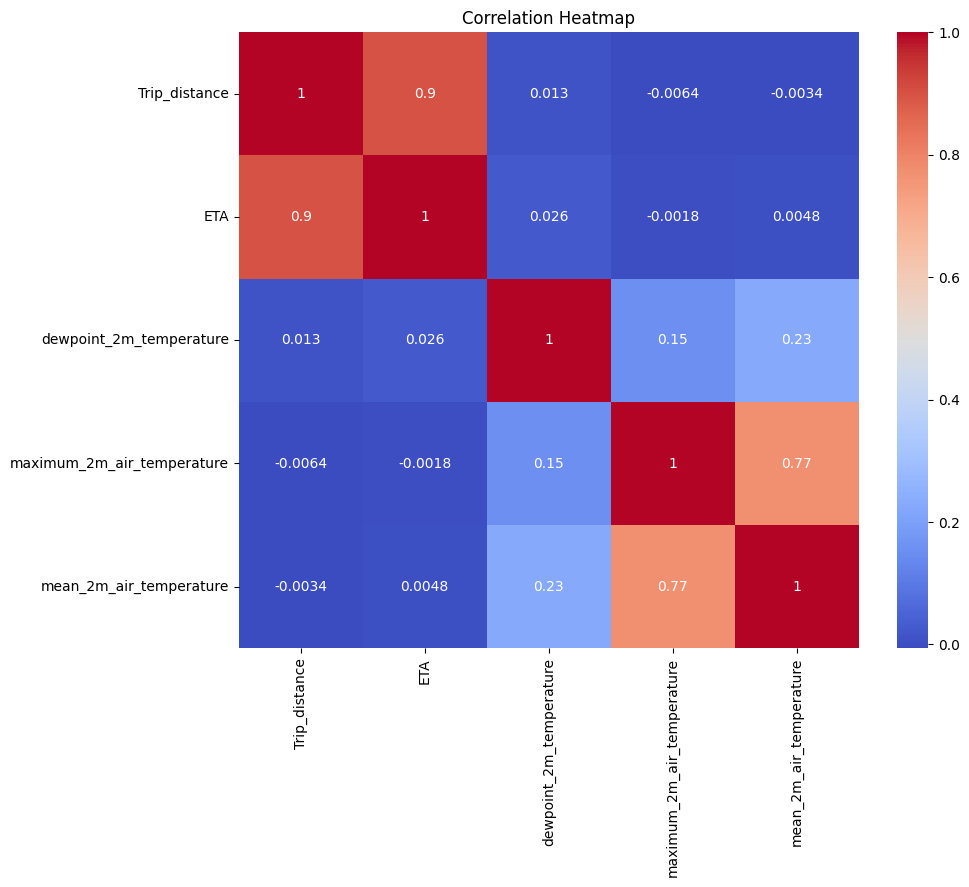

In [ ]:
# Correlation Heatmap
correlation_matrix = train[['Trip_distance', 'ETA', 'dewpoint_2m_temperature',
                         'maximum_2m_air_temperature', 'mean_2m_air_temperature']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

We therefore accept our null hypothesis which states that ETA is mostly determined by trip distance.

 1. Is the train data complete?

In [ ]:
# create a function to check for missing extracted dates
def get_missing_dates(df):
  col = df.index
  missing_dates = (pd.date_range(

      start=col.min(), #start date
      end=col.max())   #end_date
      .difference(col))
  print(f"we have {len(missing_dates)} dates missing out of {len(col)}")
  print(f"start: {col.min()}, end: {col.max()}")
  return missing_dates

In [ ]:
get_missing_dates(train)

we have 31 dates missing out of 83766
start: 2019-11-19, end: 2019-12-19


DatetimeIndex(['2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15', '2019-12-16',
               '2019-12-17', '2019-12-18', '2019-12-19'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
get_missing_dates(test)

we have 12 dates missing out of 35625
start: 2019-12-20, end: 2019-12-31


DatetimeIndex(['2019-12-20', '2019-12-21', '2019-12-22', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='D')

we can see above the the training data is incomplete. So we will fill in the missing dates

In [ ]:
def fill_missing_dates(df):
  missing_dates = (pd.DataFrame(
      pd.date_range(
        start=df.index.min(), end=df.index.max())
        .difference(df.index)
  , columns=['date']))

  #add missing df dates
  df = pd.concat([df, missing_dates], ignore_index=True)

  #filling missing df values
  cols = df.columns
  for col in cols:
    df[col] = df[col].ffill().bfill()
  return df

train = fill_missing_dates(train)
test = fill_missing_dates(test)

2. Do we have seasonality in ETA?

In [ ]:
# Assuming your time series data is stored in the variable 'eta_data'
eta_data = train['ETA']

In [ ]:
# Perform KPSS test
kpss_result = kpss(eta_data)
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]

In [ ]:
print("\nKPSS Test:")
print("KPSS Statistic:", kpss_statistic)
print("p-value:", kpss_pvalue)


KPSS Test:
KPSS Statistic: 0.6261575351853694
p-value: 0.02025840589223914


stationary if p-value > 0.05

series is stationary since 0.02 < 0.05

In [ ]:
# Perform the ADF test
result = adfuller(train['ETA'])

# Extract and print the results
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Check the p-value against a significance level (e.g., 0.05) to make a decision about stationarity
if p_value <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -31.050578175655584
p-value: 0.0
The time series is likely stationary.


In [ ]:
train.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,total_secs,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
date,,,,,,,,,,,,,,,,
2019-11-19,3.021,36.751,3.031,36.769,3898,556,82808,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467
2019-11-19,2.972,36.760,3.006,36.728,5861,785,82810,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467
2019-11-19,2.850,36.682,3.048,36.784,26065,1661,82838,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467
2019-11-19,2.984,36.757,3.005,36.777,4943,629,82844,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467
2019-11-19,2.861,36.761,3.186,36.721,37492,2181,82853,281.222931,288.498199,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467


3. What is the distribution of ETA?

In [ ]:
# Distribution of ETA:
print("Mean ETA:", train['ETA'].mean())
print("Median ETA:", train['ETA'].median())
print("Standard Deviation of ETA:", train['ETA'].std())

Mean ETA: 1111.9316429100113
Median ETA: 1054.0
Standard Deviation of ETA: 563.6417384674885


4. What is the distribution of trip distances?

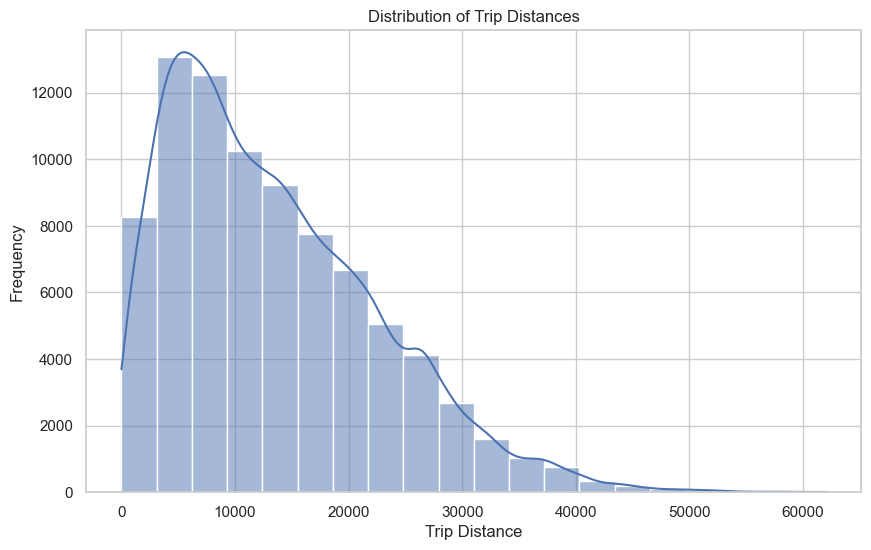

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# Question 1: Distribution of Trip Distances
plt.figure(figsize=(10, 6))
sns.histplot(train['Trip_distance'], bins=20, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.show()

5. How does ETA vary over time? Is there a trend?

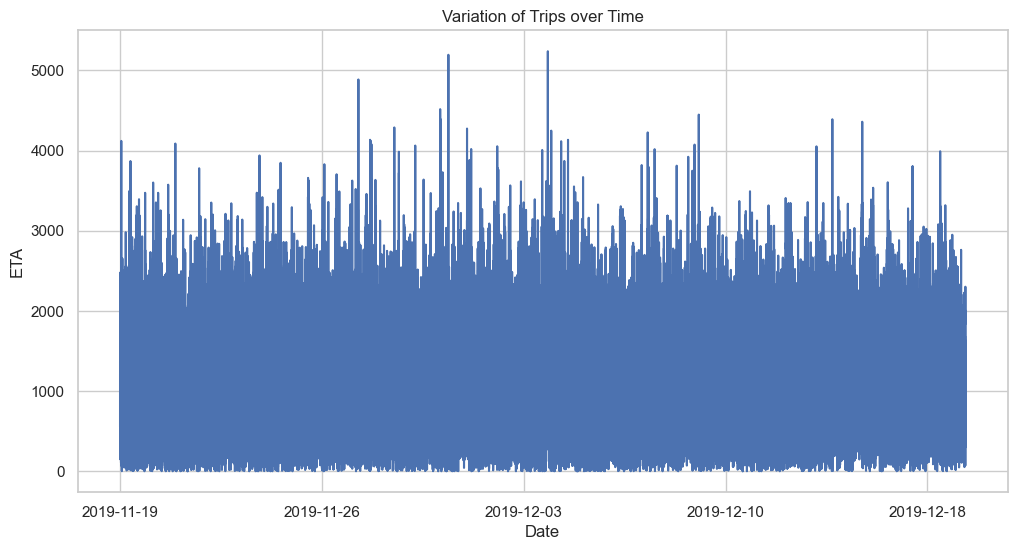

In [ ]:
# Question 2: Variation of Trips over Time
plt.figure(figsize=(12, 6))
train['ETA'].plot()
plt.title('Variation of Trips over Time')
plt.xlabel('Date')
plt.ylabel('ETA')
plt.show()

There is no trend in ETA over time.

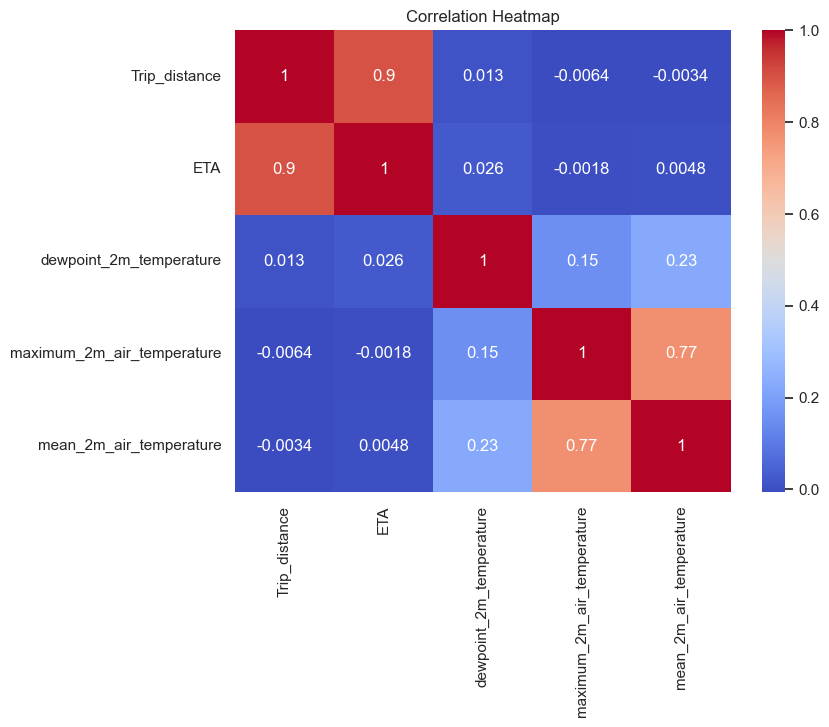

In [ ]:
# Question 3: Correlation Heatmap
correlation_matrix = train[['Trip_distance', 'ETA', 'dewpoint_2m_temperature',
                         'maximum_2m_air_temperature', 'mean_2m_air_temperature']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

maximum_2m_air_temperature and mean_2m_air_temperature have a high correlation of 0.77 or 77%

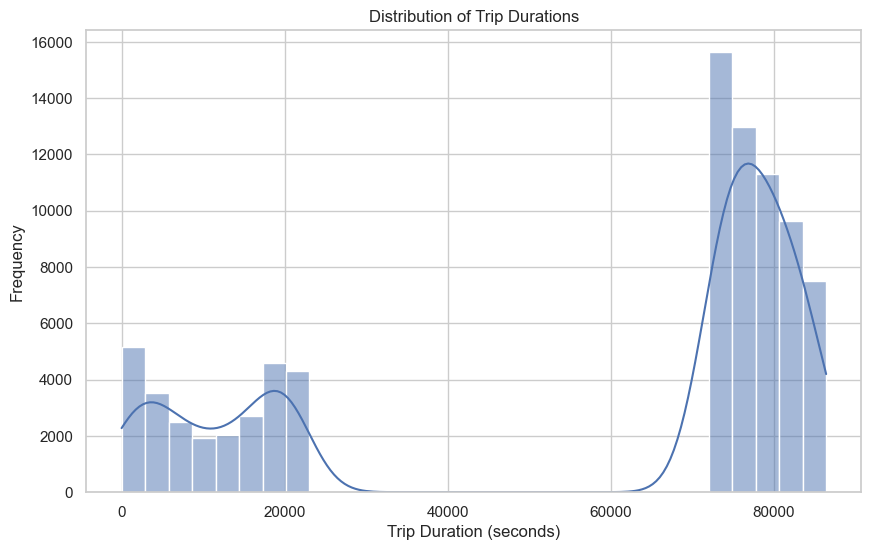

In [ ]:
# Question 4: Distribution of Trip Durations
plt.figure(figsize=(10, 6))
sns.histplot(train['total_secs'], bins=30, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

## Features Encoding & scaling

In [ ]:
numeric_columns = train.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
categoric_columns = [col for col in train.columns if col not in numeric_columns]
categoric_columns

[]

In [ ]:
numeric_columns.remove('ETA')
print(numeric_columns)

['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon', 'Trip_distance', 'total_secs', 'dewpoint_2m_temperature', 'maximum_2m_air_temperature', 'mean_2m_air_temperature', 'mean_sea_level_pressure', 'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation', 'u_component_of_wind_10m', 'v_component_of_wind_10m']


### Scaling

In [ ]:
# Create an instance of StandardScaler and set output to be a DataFrame
scaler = StandardScaler().fit(train[numeric_columns]).set_output(transform="pandas")

num = scaler.transform(train[numeric_columns])
num_test = scaler.transform(test[numeric_columns])

In [ ]:
train = pd.concat([num, train['ETA']], axis=1)
test = num_test

## Splitting

In [ ]:
cut_num = len(train) * 0.12
cut_num = int(cut_num)

In [ ]:
train, eval_set = train[cut_num:], train[:cut_num]

In [ ]:
# Split data into parts
x = train.drop(['ETA'], axis = 1)
y = train['ETA']

In [ ]:
cut_num = len(train) * 0.2
cut_num = int(cut_num)

In [ ]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[cut_num:], x[:cut_num], y[cut_num:], y[:cut_num]

# Machine Learning Modeling

# Non-Traditional Time Series Models

### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Initialize and fit the Random Forest Regressor
forest = RandomForestRegressor()
model_forest = forest.fit(X_train, y_train)

# Make predictions on X_test
forest_pred = model_forest.predict(X_test)

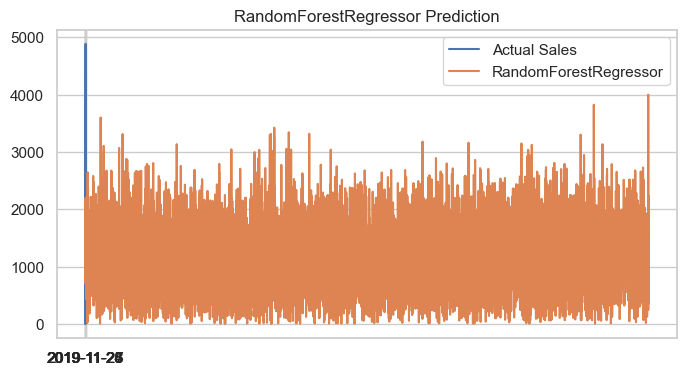

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='Actual Sales')
plt.plot(forest_pred, label='RandomForestRegressor')
plt.legend(loc='best')
plt.title('RandomForestRegressor Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, forest_pred)
msle = mean_squared_log_error(y_test, forest_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Append the results to the DataFrame
results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,34652.868312,0.035809,186.15,0.18923


### XGboost

In [ ]:
import xgboost as xgb

# Initialize and fit the XGBoost model
xgboost = xgb.XGBRegressor()
model_xgboost = xgboost.fit(X_train, y_train)

# Make predictions on X_test
xgboost_pred = model_xgboost.predict(X_test)

# Append the results to the DataFrame
mse = mean_squared_error(y_test, xgboost_pred)
# msle = mean_squared_log_error(y_test, xgboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,34652.868312,0.035809,186.15,0.18923
1,XGBoost,26463.839811,0.035809,162.68,0.18923


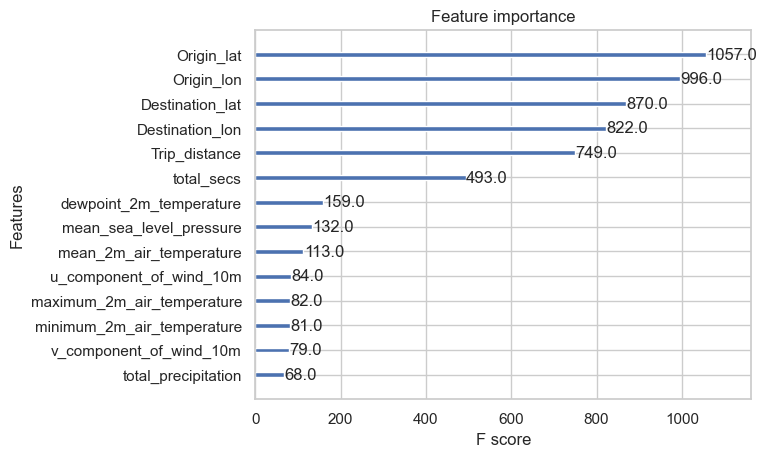

Origin_lat: 1057.0
Origin_lon: 996.0
Destination_lat: 870.0
Destination_lon: 822.0
Trip_distance: 749.0
total_secs: 493.0
dewpoint_2m_temperature: 159.0
mean_sea_level_pressure: 132.0
mean_2m_air_temperature: 113.0
u_component_of_wind_10m: 84.0
maximum_2m_air_temperature: 82.0
minimum_2m_air_temperature: 81.0
v_component_of_wind_10m: 79.0
total_precipitation: 68.0


In [ ]:
import matplotlib.pyplot as plt

# Using plot_importance function to visualize feature importance
xgb.plot_importance(model_xgboost)
plt.show()

# Alternatively, you can use the get_booster() method to get the booster object
booster = model_xgboost.get_booster()

# Get the feature importance scores
importance_scores = booster.get_score(importance_type='weight')

# Sort the importance scores in descending order
sorted_importance_scores = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Print the sorted importance scores
for feature, score in sorted_importance_scores:
    print(f"{feature}: {score}")

# Models Comparison

In [ ]:
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,34652.868312,0.035809,186.15,0.18923
1,XGBoost,26463.839811,0.035809,162.68,0.18923


# Model Evaluation (eval_set)

In [ ]:
# Split data into parts
x_eval = eval_set.drop(['ETA'], axis = 1)
y_eval = eval_set['ETA']

In [ ]:
xgboost_pred_eval = model_xgboost.predict(x_eval)
mse = mean_squared_error(y_eval, xgboost_pred_eval)
rmse = np.sqrt(mse).round(2)
rmse

148.13

### predicting sales in our test

In [ ]:
test_pred = model_xgboost.predict(test)
test_pred

array([1522.2935 ,  784.54065, 1056.2034 , ...,  627.60925, 1271.2261 ,
        587.2578 ], dtype=float32)

In [ ]:
test_copy['ETA'] = test_pred
sub = test_copy[['ID', 'ETA']]
sub

,ID,ETA
0,000V4BQX,1522.293457
1,003WBC5J,784.540649
2,004O4X3A,1056.203369
3,006CEI5B,1827.367676
4,009G0M2T,662.266174
...,...,...
35620,ZZXSJW3Q,454.342285
35621,ZZYPNYYY,1064.614258
35622,ZZYVPKXY,627.609253
35623,ZZZXGRIO,1271.226074


In [ ]:
# Save sample submission
sub.to_csv('submission.csv')

In [ ]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('model.pkl', 'wb') as f:
    pickle.dump(model_xgboost, f)